# Camera Configuration Diagnostics

The purpose of this notebook is to examine the accuracy of the camera array configuration both before and after bundle adjustment.

In [10]:
from pathlib import Path
import pickle
import sys
import numpy as np
import pandas as pd

# some convenient reference paths
repo = str(Path.cwd()).split("src")[0]
# update path
sys.path.insert(0, repo)
# which enables import of relevant class
# from src.cameras.camera_array import ArrayDiagnosticData
from src.calibration.bundle_adjustment.point_data import PointData
from src.calibration.bundle_adjustment.calibration_diagnostics import (
    get_charuco,
    create_summary_df,
    get_diagnostic_data,
)


# calibration_directory = Path(repo, "sessions", "iterative_adjustment", "recording")
calibration_directory = Path(repo, "sessions", "default_res_session", "recording")
before_path = Path(calibration_directory, "before_bund_adj.pkl")
after_path = Path(calibration_directory, "after_bund_adj.pkl")

before = get_diagnostic_data(before_path)
after = get_diagnostic_data(after_path)

before_df = create_summary_df(before_path, "before")
after_df = create_summary_df(after_path, "after")

before_and_after = pd.concat([before_df, after_df])


## (x,y) Reprojection Error

In [2]:
before_and_after.groupby(["label"])["reproj_error"].describe()


,count,mean,std,min,25%,50%,75%,max
label,,,,,,,,
after,6962.0,2.681289,2.083518,0.000182,1.128379,2.228033,3.669190,19.004088
before,6962.0,188.654705,97.030978,7.793576,115.847998,177.726313,243.639442,598.362617


In [3]:
reproj_error = before_and_after.query("label == 'before'")["reproj_error"].to_numpy()
rmse = np.sqrt(np.mean(reproj_error**2))
print(f"RMSE of reprojection prior to bundle adjustment is {rmse}")

reproj_error = before_and_after.query("label == 'after'")["reproj_error"].to_numpy()
rmse = np.sqrt(np.mean(reproj_error**2))
print(f"RMSE of reprojection after bundle adjustment is {rmse}")

RMSE of reprojection prior to bundle adjustment is 212.14206614683792
RMSE of reprojection after bundle adjustment is 3.3955459168038655


In [4]:

before_and_after.groupby(["camera", "label"])["reproj_error"].describe()

count        mean        std         min         25%  \
camera label                                                           
0      after   2094.0    3.220848   2.219307    0.006651    1.671410   
       before  2094.0  281.915394  89.894310  100.962179  224.516600   
1      after   2424.0    2.353893   1.841369    0.000182    0.849688   
       before  2424.0  119.013094  64.689005    7.793576   75.938321   
2      after   2444.0    2.543714   2.100437    0.000292    1.037854   
       before  2444.0  177.821392  58.038387   77.745386  131.048022   

                      50%         75%         max  
camera label                                       
0      after     2.741476    4.256390   19.004088  
       before  261.684080  320.466101  598.362617  
1      after     1.959822    3.497341   12.203091  
       before  108.755163  141.893588  424.401895  
2      after     2.002915    3.365692   15.689789  
       before  175.686473  207.623615  364.700816

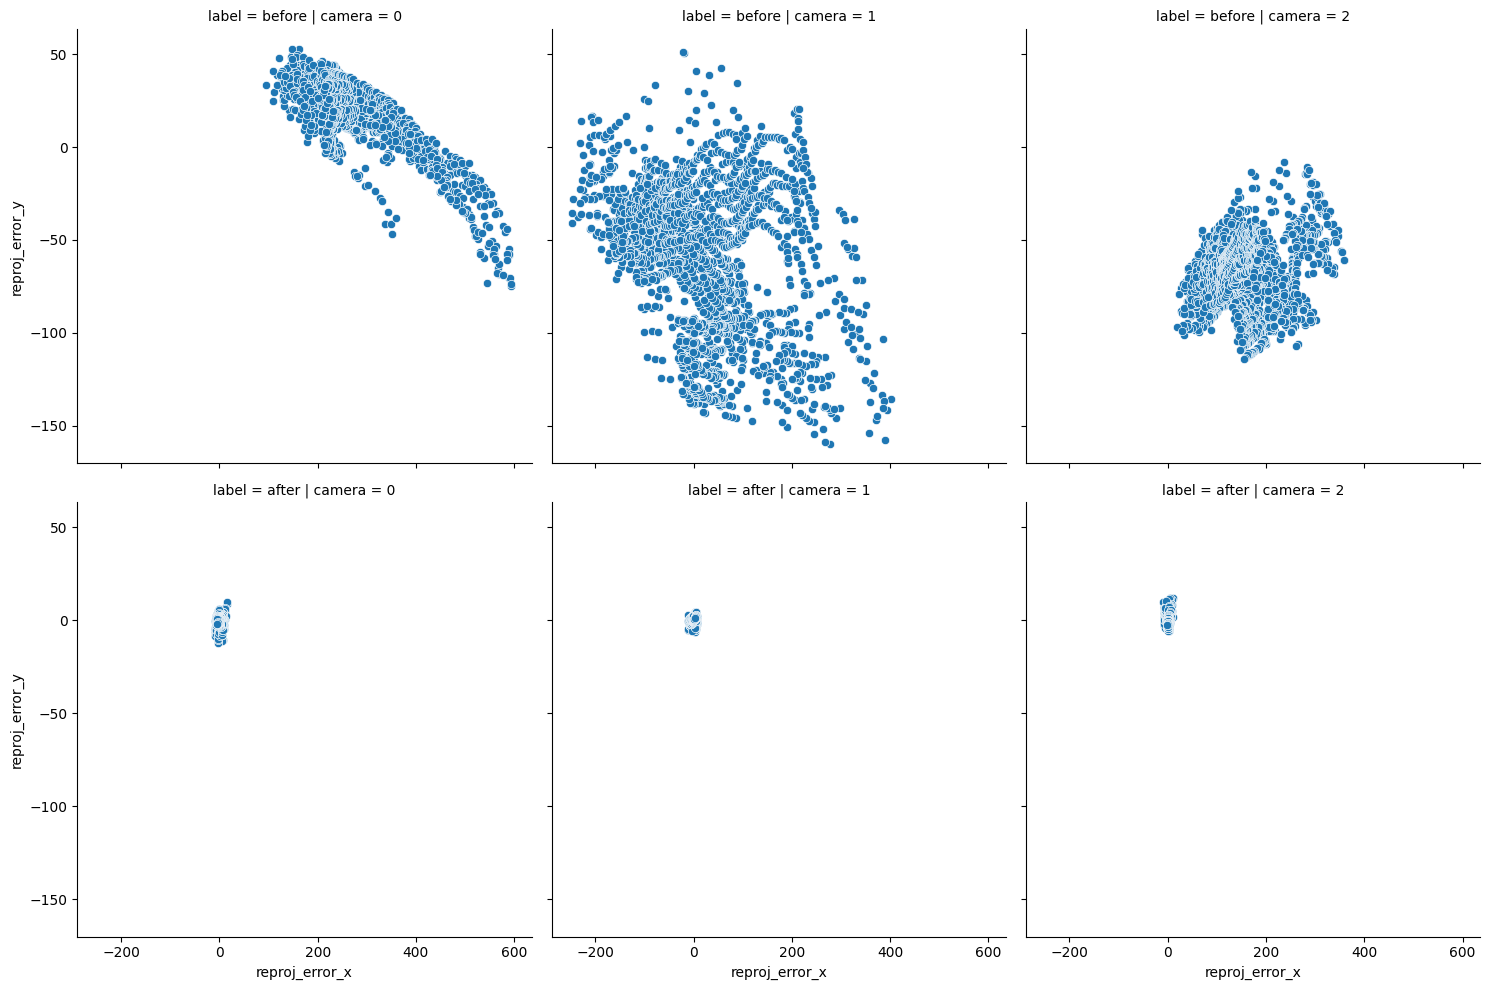

In [5]:
import seaborn as sns

sns.relplot(
    data=before_and_after,
    x="reproj_error_x",
    y="reproj_error_y",
    col="camera",
    row="label",
    kind="scatter",
)

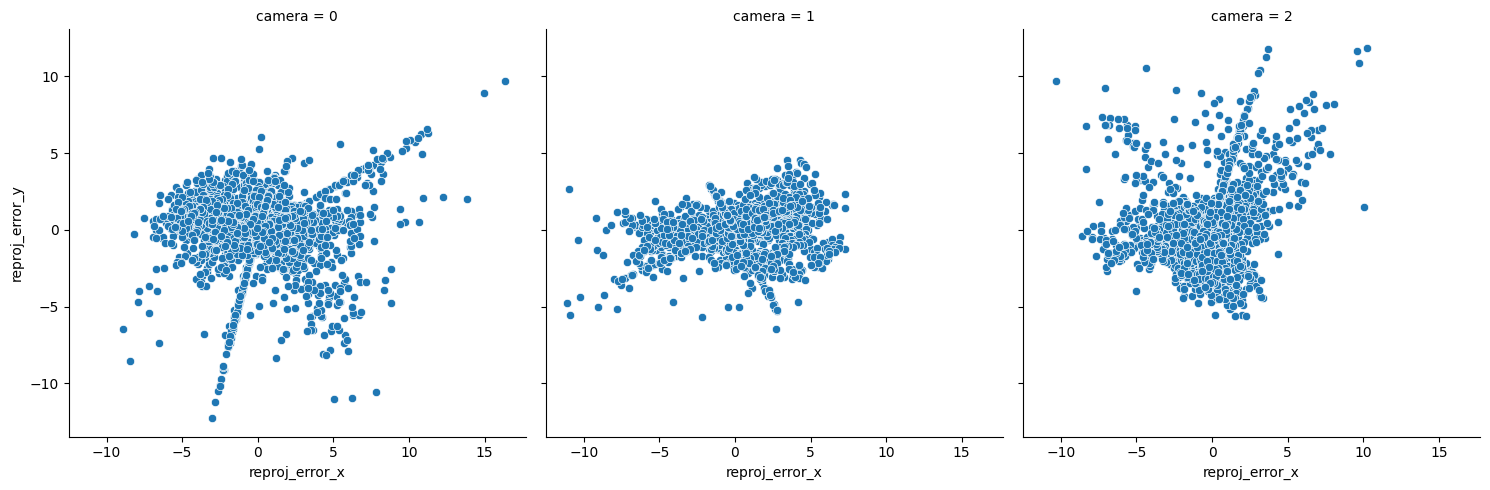

In [6]:

sns.relplot(
    data=after_df,
    x="reproj_error_x",
    y="reproj_error_y",
    col="camera",
    # row="label",
    kind="scatter",
)

## Euclidian Distance Reprojection Error 

### Histogram Before and After

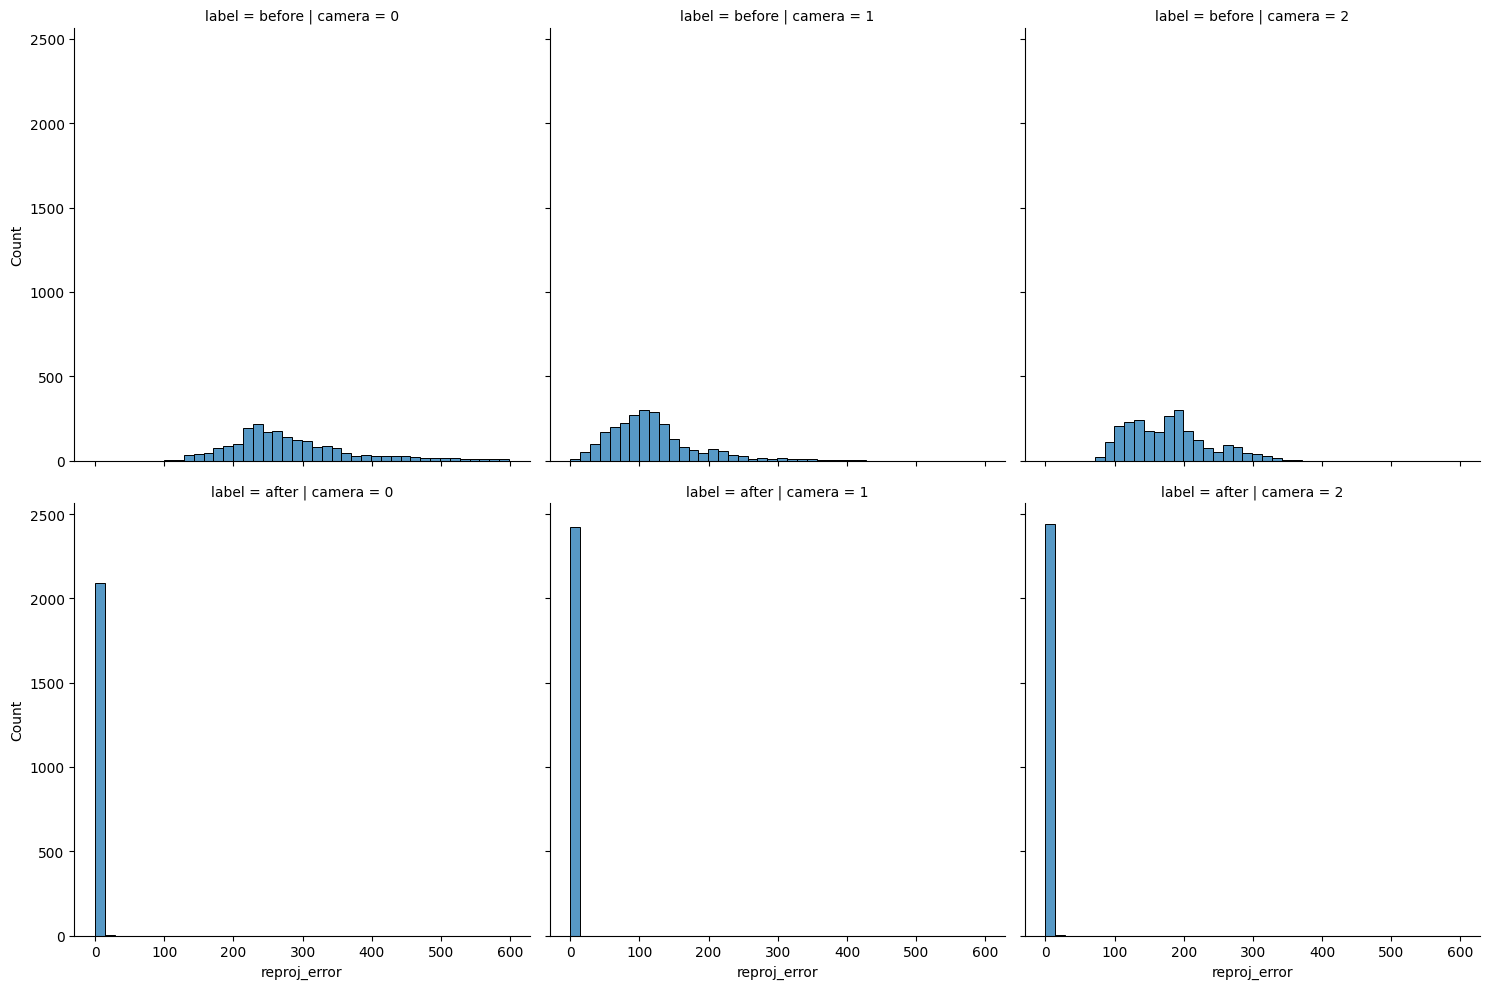

In [7]:

sns.displot(
    data= before_and_after,
    x="reproj_error",
    col="camera",
    row="label",
)

### Box Plot Before and After

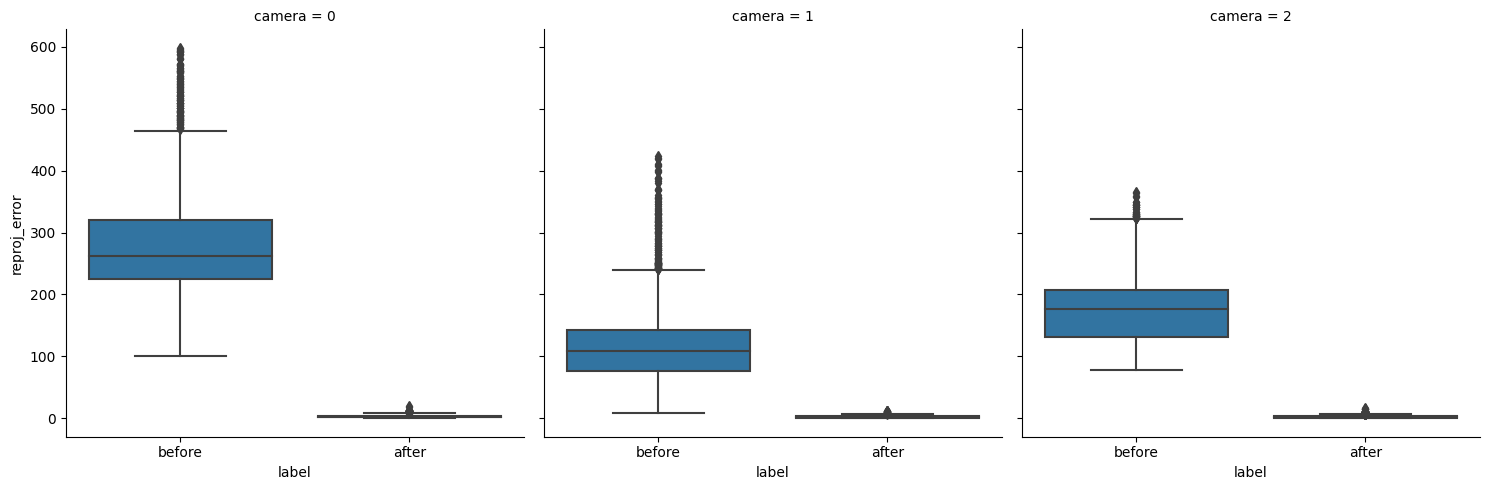

In [8]:
sns.catplot(
    data=before_and_after, 
    x="label", 
    y="reproj_error", 
    col="camera", 
    kind="box"
)

## Charuco Corner Distance

In [13]:
# Get array of chessboard_ids and locations in a board frame of referencefrom before_and_after


config_path = Path(calibration_directory.parent, "config.toml")
charuco = get_charuco(config_path)

corners = before_and_after["charuco_id"].to_numpy()
xyz_corner_loc = charuco.board.chessboardCorners[corners, :]

corners_3d = (before_and_after[
    ["label", "sync_index", "charuco_id", "obj_id", "obj_x", "obj_y", "obj_z"]
]
                .groupby(["label","obj_id"])
                .mean()
                .reset_index()
)


In [14]:

from itertools import combinations

labels = corners_3d["label"].unique()
corner_ids = corners_3d["charuco_id"].unique()

corner_distances = {
    "label": [],
    "sync_index": [],
    "pair": [],
    "distance_true": [],
    "distance_measured": [],
}


for label in labels:
    by_label_df = corners_3d[corners_3d["label"] == label]
    # sub_df = corners_3d.filter
    sync_indices = by_label_df["sync_index"].unique()

    for sync_index in sync_indices:
        by_sync_index_df = by_label_df[by_label_df["sync_index"] == sync_index]
        corners = by_sync_index_df["charuco_id"]
        pairs = combinations(corners.tolist(), 2)

        corner_loc_world = by_sync_index_df[["obj_x", "obj_y", "obj_x"]].to_numpy()
        charuco_id = by_sync_index_df[["charuco_id"]]


        for pair in pairs:
            # print(pair)
            loc_A_board = charuco.board.chessboardCorners[int(pair[0])]
            loc_B_board = charuco.board.chessboardCorners[int(pair[1])]

            distance_true = np.sqrt(np.sum((loc_A_board - loc_B_board) ** 2))

            loc_A_world = by_sync_index_df[by_sync_index_df["charuco_id"] == pair[0]][
                ["obj_x", "obj_y", "obj_z"]
            ].to_numpy()[0]

            loc_B_world = by_sync_index_df[by_sync_index_df["charuco_id"] == pair[1]][
                ["obj_x", "obj_y", "obj_z"]
            ].to_numpy()[0]
            
            distance_measured = np.sqrt(np.sum((loc_A_world - loc_B_world) ** 2))

            corner_distances["label"].extend([label])
            corner_distances["sync_index"].extend([sync_index])
            corner_distances["pair"].extend([pair])
            corner_distances["distance_true"].extend([distance_true])
            corner_distances["distance_measured"].extend([distance_measured])

        print(f"{label}: Sync Index {sync_index}")
        # for corner_id in corner_ids:

after: Sync Index 77.0
after: Sync Index 78.0
after: Sync Index 79.0
after: Sync Index 80.0
after: Sync Index 81.0
after: Sync Index 82.0
after: Sync Index 83.0
after: Sync Index 84.0
after: Sync Index 85.0
after: Sync Index 86.0
after: Sync Index 87.0
after: Sync Index 88.0
after: Sync Index 89.0
after: Sync Index 90.0
after: Sync Index 91.0
after: Sync Index 92.0
after: Sync Index 93.0
after: Sync Index 94.0
after: Sync Index 95.0
after: Sync Index 96.0
after: Sync Index 97.0
after: Sync Index 98.0
after: Sync Index 99.0
after: Sync Index 100.0
after: Sync Index 101.0
after: Sync Index 102.0
after: Sync Index 103.0
after: Sync Index 104.0
after: Sync Index 105.0
after: Sync Index 106.0
after: Sync Index 107.0
after: Sync Index 108.0
after: Sync Index 109.0
after: Sync Index 110.0
after: Sync Index 111.0
after: Sync Index 112.0
after: Sync Index 113.0
after: Sync Index 114.0
after: Sync Index 115.0
after: Sync Index 116.0
after: Sync Index 117.0
after: Sync Index 118.0
after: Sync Ind

In [15]:
corner_distances_df = pd.DataFrame(corner_distances)
corner_distances_df = corner_distances_df.assign(distance_true = lambda x: round(x.distance_true,4),
                           Distance_error_m = lambda x: round(x.distance_true - x.distance_measured,4),
                           Distance_error_mm = lambda x: x.Distance_error_m * 1000,
                           Distance_error_mm_abs = lambda x: abs(x.Distance_error_mm),
                           Distance_error_pct = lambda x: x.Distance_error_mm/ x.distance_true )


## Percentiles of Absolute Value of Distance Error (mm)

In [16]:
corner_distances_df.groupby("label")["Distance_error_mm_abs"].describe()

,count,mean,std,min,25%,50%,75%,max
label,,,,,,,,
after,12740.0,33.941947,16.969969,0.0,20.4,31.1,45.3,102.3
before,12740.0,37.680502,48.586125,0.0,11.3,20.2,36.5,486.3


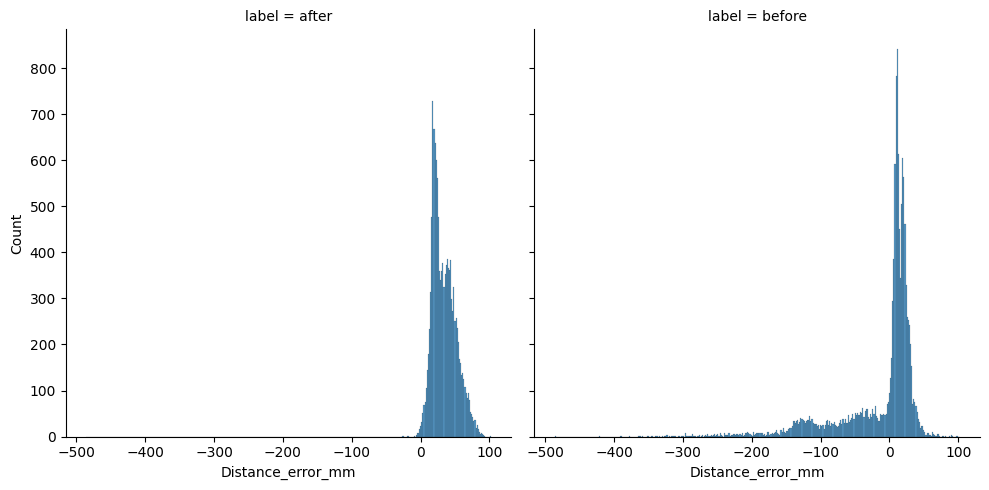

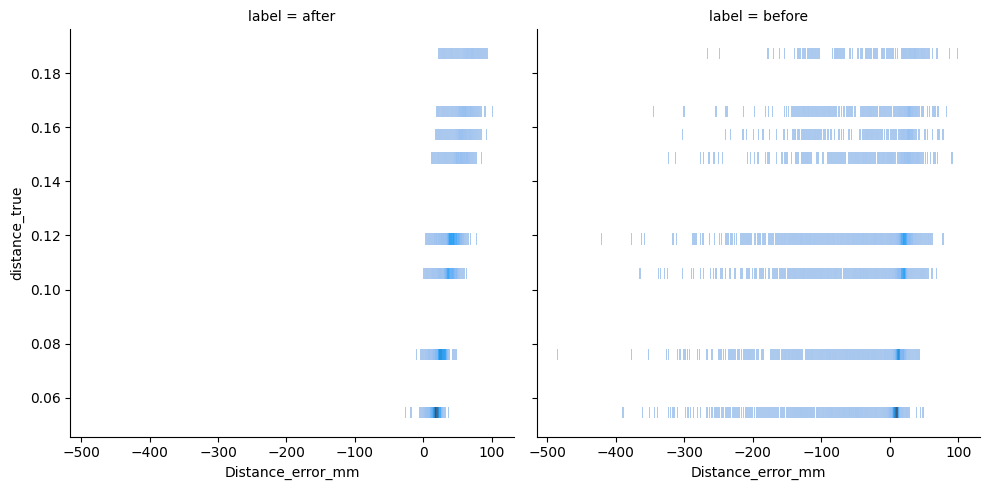

In [17]:
sns.displot(data=corner_distances_df, col="label", x="Distance_error_mm")
sns.displot(data=corner_distances_df, col="label", x="Distance_error_mm", y = "distance_true")

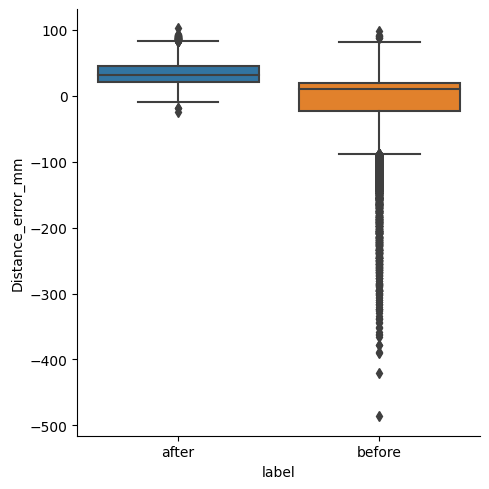

In [18]:

# sns.catplot(data=corner_distances_df, col="label", x="Distance_error_mm", kind="Box")

sns.catplot(
    data=corner_distances_df, 
    x="label", 
    y="Distance_error_mm", 
    kind="box"
)

## Corner Distance Calculations Exclusively in Numpy

Here I'm going to attempt to match the calculations above without any use of pandas. I'll do each batch seperately...and primarily rely upon the PointData structure so that any code could be adapted to a bundle adjustment residual function relatively easy.